In [2]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import timeit
import time

<h1>Load training, validation, testing set from your preprocessed files</h1>

In [5]:
train_set = []
test_set = []
val_set = []
for i in range(10):
    with open('train/train'+str(i)+'.pkl', 'rb') as f:
        train_set += pickle.load(f)
    with open('test/test'+str(i)+'.pkl', 'rb') as ft:
        test_set += pickle.load(ft)
with open('val/validation.pkl', 'rb') as fv:
    val_set += pickle.load(fv)
print("Size of training set: ",len(train_set),'\n')
print("Size of test set: ",len(test_set),'\n')
print("Size of validation set: ",len(val_set),'\n')

Size of training set:  24500 

Size of test set:  12500 

Size of validation set:  500 



In [51]:
print(test_set[0].shape)

(1, 227, 227, 3)


<h1>Define hyperparameter</h1>

In [40]:
batch_size = 128
lr = 0.0001
epoch = 10
dropout_rate = 0.5
inp_size = 227
conv1 = {"size": 11, "nums": 96, "stride": 4}
conv2 = {"size": 5, "nums": 256, "stride": 1, "padding": 2}
conv3 = {"size": 3, "nums": 384, "stride": 1, "padding": 1}
conv4 = {"size": 3, "nums": 384, "stride": 1, "padding": 1}
conv5 = {"size": 3, "nums": 256, "stride": 1, "padding": 1}
maxPool = {"size": 3, "stride": 2}
conv_out_size = 6
hidden_size1 = 512
hidden_size2 = 512
out_size = 2

In [41]:
pass_num = len(train_set) // batch_size
def get_batch(i, size):
    inp = [inp[0] for inp in train_set[(i * size):((i + 1) * size)]]
    label = [lab[1] for lab in train_set[(i * size):((i + 1) * size)]]
    X_inp = np.empty((len(inp), inp_size, inp_size, 3), dtype=np.float32)
    y_label = np.empty((len(inp),2), dtype=np.float32)
    for j in range(len(inp)):
        X_inp[j] = inp[j]
        y_label[j] = label[j]
    return (X_inp, y_label)

def val_data():
    inp = [inp[0] for inp in val_set]
    label = [lab[1] for lab in val_set]
    X_inp = np.empty((len(inp), inp_size, inp_size, 3), dtype=np.float32)
    y_label = np.empty((len(inp),2), dtype=np.float32)
    for j in range(len(inp)):
        X_inp[j] = inp[j]
        y_label[j] = label[j]
    return (X_inp, y_label)
val_x, val_y = val_data()
print(val_x.shape, val_y.shape)

(500, 227, 227, 3) (500, 2)


<h1>Placeholder</h1>

In [42]:
tf.reset_default_graph()
with tf.name_scope("data"):
    X = tf.placeholder(dtype=tf.float32, shape=[None, 227, 227, 3])
    y = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    training = tf.placeholder_with_default(False, shape=())

<h1>AlexNet</h1>

In [43]:
'''
tf.layers.conv2d(
    inputs,
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format='channels_last',
    dilation_rate=(1, 1),
    activation=None)
tf.contrib.layers.max_pool2d(
    inputs,
    kernel_size,
    stride=2,
    padding='VALID')

tf.layers.dense(
    inputs,
    units,
    activation=None,
    use_bias=True)
'''
def AlexNet(X):
    layer1_out = tf.layers.conv2d(X, conv1["nums"], conv1["size"], conv1["stride"], 'valid', activation=tf.nn.relu)
    maxPool1_out = tf.contrib.layers.max_pool2d(layer1_out, maxPool["size"], maxPool["stride"], 'VALID')
    out1 = tf.nn.lrn(maxPool1_out)
    
    layer2_out = tf.layers.conv2d(out1, conv2["nums"], conv2["size"], conv2["stride"], 'same', activation=tf.nn.relu)
    maxPool2_out = tf.contrib.layers.max_pool2d(layer2_out, maxPool["size"], maxPool["stride"], 'VALID')
    out2 = tf.nn.lrn(maxPool2_out)

    out3 = tf.layers.conv2d(out2, conv3["nums"], conv3["size"], conv3["stride"], 'same', activation=tf.nn.relu)
    out4 = tf.layers.conv2d(out3, conv4["nums"], conv4["size"], conv4["stride"], 'same', activation=tf.nn.relu)
    out5 = tf.layers.conv2d(out4, conv5["nums"], conv5["size"], conv5["stride"], 'same', activation=tf.nn.relu)
    
    maxPool5_out = tf.contrib.layers.max_pool2d(out5, maxPool["size"], maxPool["stride"], 'VALID')
    layer5_drop = tf.layers.dropout(maxPool5_out, dropout_rate,  training=training)
    layer5_reshape = tf.reshape(layer5_drop, shape=[-1, conv5["nums"] * conv_out_size * conv_out_size])
    fc1 = tf.layers.dense(layer5_reshape, hidden_size1, activation=tf.nn.relu, use_bias=True)
    fc1_drop = tf.layers.dropout(fc1, dropout_rate,  training=training)
    fc2 =  tf.layers.dense(fc1, hidden_size2, activation=tf.nn.relu, use_bias=True)
    out = tf.layers.dense(fc2, out_size, activation=tf.nn.softmax, use_bias=True)
    return out
out = AlexNet(X)


<h1>Cost and Optimization</h1>

In [44]:
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out)
correct_pred = tf.equal(tf.argmax(out,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

<h1>Training and validation</h1>
<h2>Train your model only 10 epochs</h2>
<p style="font-size:20px">1. Print out training accuracy and validation accuracy each training epoch</p>
<p style="font-size:20px">2. Print out training time each training epoch</p>
<p style="font-size:20px">3. Your goal is to reach 85% validation accuracy in 10 training epochs. If you reach that, you can perform testing, print out your test accuracy. Plot out the ten images with title that contains the probability of the labeled class.</p>

In [45]:
start = time.time()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for i in range(epoch):
        for j in range(pass_num):
            batch_x, batch_y = get_batch(j, batch_size)
            sess.run(train_op, feed_dict={X:batch_x, y:batch_y, training:True})
            if j == pass_num - 1:
                tr_acc = sess.run(accuracy,feed_dict={X:batch_x, y:batch_y})
                print("epoch "+str(i)+", Training accuracy= {:.3f}".format(tr_acc))
        val_acc = sess.run(accuracy,feed_dict={X:val_x, y:val_y})
        print("epoch "+str(i)+", Validation accuracy= {:.3f}".format(val_acc))
        print("time elapsed at "+str(i)+"th epoch is: ", int(time.time() - start), " seconds")
    save_path = saver.save(sess, 'model.ckpt')
    print("Training finished!")

epoch 0, Training accuracy= 0.703
epoch 0, Validation accuracy= 0.646
time elapsed at 0th epoch is:  87  seconds
epoch 1, Training accuracy= 0.758
epoch 1, Validation accuracy= 0.692
time elapsed at 1th epoch is:  170  seconds
epoch 2, Training accuracy= 0.789
epoch 2, Validation accuracy= 0.712
time elapsed at 2th epoch is:  253  seconds
epoch 3, Training accuracy= 0.828
epoch 3, Validation accuracy= 0.782
time elapsed at 3th epoch is:  336  seconds
epoch 4, Training accuracy= 0.828
epoch 4, Validation accuracy= 0.802
time elapsed at 4th epoch is:  419  seconds
epoch 5, Training accuracy= 0.867
epoch 5, Validation accuracy= 0.792
time elapsed at 5th epoch is:  502  seconds
epoch 6, Training accuracy= 0.891
epoch 6, Validation accuracy= 0.852
time elapsed at 6th epoch is:  585  seconds
epoch 7, Training accuracy= 0.844
epoch 7, Validation accuracy= 0.796
time elapsed at 7th epoch is:  669  seconds
epoch 8, Training accuracy= 0.891
epoch 8, Validation accuracy= 0.846
time elapsed at 8th

INFO:tensorflow:Restoring parameters from model.ckpt


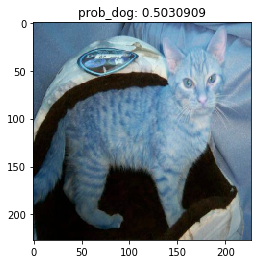

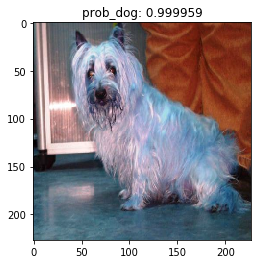

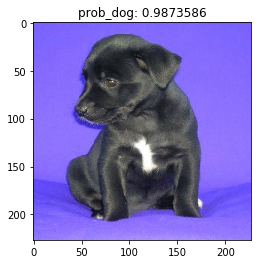

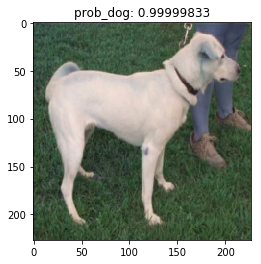

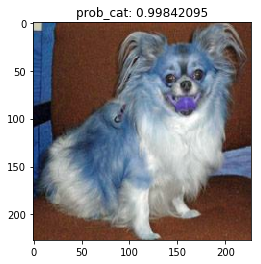

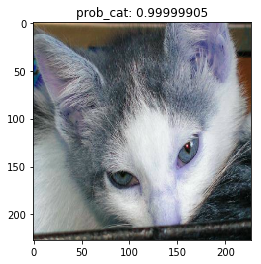

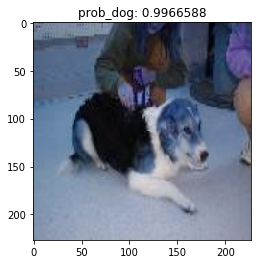

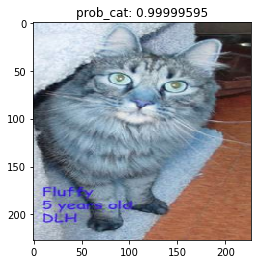

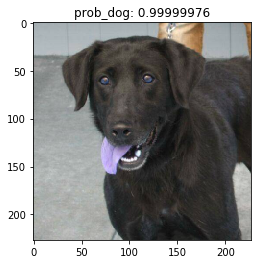

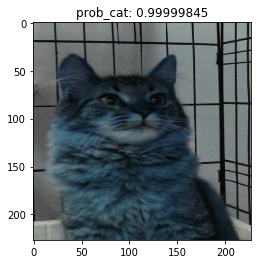

In [58]:
with tf.Session() as sess:
    saver.restore(sess, "model.ckpt")
    for i in range(10):
        pred = sess.run(out, feed_dict = {X:test_set[i]})
        pred = np.squeeze(pred)
        result = "prob_cat: "+str(pred[0])
        if (pred[1] > pred[0]):
            result = "prob_dog: "+str(pred[1])
        fig = plt.figure()
        plt.imshow(np.squeeze(test_set[i]))
        plt.title(result)